In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-01-22 19:30:45.965479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Max mutual information vs sampling density for different samples

In [ ]:
# N_objects = 5000
# num_bootstraps = 1
# noise_sigma = 1e-3
# num_samples = np.arange(2, 32, 4).astype(int)

# objects_dict = {
#   'delta_uniform': lambda : np.array([generate_random_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)]),
#   # 'delta_nonuniform': lambda: np.array([generate_random_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)]),
#   'white_noise': lambda : np.array([generate_random_object('white_noise') for i in range(N_objects)]),
#   # 'pink_noise': lambda : np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)]),
#   '8_deltas_uniform': lambda :np.array([generate_random_object('delta', num_deltas=8, gaussian_mixture_position=False) for i in range(N_objects)]),
#   # '8_deltas_nonuniform': lambda : np.array([sample_amplitude_object('delta', num_deltas=8, gaussian_mixture_position=True) for i in range(N_objects)]),
# }

# num_nyquist_samples = 16

# mi_by_object = {}
# for name, objects_fn in objects_dict.items():
#   print(name)
#   mutual_information = []
#   for N in tqdm(num_samples):
#     mi_bootstraps = []
#     for k in range(num_bootstraps):
#       initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
#           objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, estimate_with_pixel_cnn=False)



#       # do the estimation
#       scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
#       test_objects = objects_fn()
#       output_signals = conv_forward_model(optimized_params, test_objects,
#                                                   integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples)
#       # interpolate to higher resolution before integrating?

      



#       noisy_output_signals = output_signals + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), output_signals.shape) * noise_sigma
#       fake_images = noisy_output_signals.reshape(-1, int(np.sqrt(num_nyquist_samples)), int(np.sqrt(num_nyquist_samples))) * scale_factor
#       if verbose:
#           print('computing optimized mi')
#       optimized_mi = estimate_mutual_information(fake_images, gaussian_noise_sigma=noise_sigma * scale_factor, verbose=False)                                                      


#       mi_bootstraps.append(optimized_mi)

#     mutual_information.append(mi_bootstraps)
#   mi_by_object[name] = mutual_information


In [7]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [4, 9, 16, 25, 36]
num_bootstrap_samples = 1
upsampling_factor = 16
max_epochs = 5000
# max_epochs = 500
confidence = 90
num_nyquist_samples = 16

object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']


mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []
  for num_samples in tqdm(num_samples_list):
    upsampled_signal_length = upsampling_factor*num_nyquist_samples
    
    if name == 'delta_uniform':
      objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
    elif name == '8_deltas_uniform':
      objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
    else:
      objects_fn = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])

    runs = []
    for i in range(num_bootstrap_samples):
      initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
          max_epochs=max_epochs, )
      
      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      output_signals = integrate_pixels(resampled_output_signals, num_samples)

      noisy_output_signals = output_signals + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), output_signals.shape) * noise_sigma

      fake_images = noisy_output_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      optimized_mi = estimate_mutual_information(fake_images, gaussian_noise_sigma=noise_sigma * scale_factor, verbose=False)                                                      

      runs.append(optimized_mi)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise


  0%|          | 0/5 [00:00<?, ?it/s]

initial loss -0.22461607119367083
computing optimized mi


 20%|██        | 1/5 [01:40<06:43, 100.97s/it]

initial loss -0.23214347902919846
computing optimized mi


 40%|████      | 2/5 [03:20<04:59, 99.91s/it] 

initial loss -0.23664744634308676
computing optimized mi


 60%|██████    | 3/5 [05:00<03:19, 99.94s/it]

initial loss -0.11429737995487685
computing optimized mi


 80%|████████  | 4/5 [06:44<01:41, 101.81s/it]

initial loss -0.2239468639955493
computing optimized mi


100%|██████████| 5/5 [08:30<00:00, 102.10s/it]


delta_uniform


  0%|          | 0/5 [00:00<?, ?it/s]

initial loss -4.063906958392124
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 20%|██        | 1/5 [01:23<05:35, 83.77s/it]

initial loss -4.046007304033729
computing optimized mi


 40%|████      | 2/5 [02:47<04:12, 84.01s/it]

initial loss -4.169993245688568
computing optimized mi


 60%|██████    | 3/5 [04:10<02:46, 83.38s/it]

initial loss -4.5755865555870106
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.42% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 80%|████████  | 4/5 [05:33<01:23, 83.38s/it]

initial loss -3.9714727134874823
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 1.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 5/5 [06:58<00:00, 83.62s/it]


8_deltas_uniform


  0%|          | 0/5 [00:00<?, ?it/s]

initial loss -2.3900338592744133
computing optimized mi


 20%|██        | 1/5 [01:22<05:29, 82.34s/it]

initial loss -2.78421905943462
computing optimized mi


 40%|████      | 2/5 [02:43<04:04, 81.37s/it]

initial loss -2.9639102612460153
computing optimized mi


 60%|██████    | 3/5 [04:04<02:43, 81.52s/it]

initial loss -2.75515118066149
computing optimized mi


 80%|████████  | 4/5 [05:27<01:21, 81.94s/it]

initial loss -2.8025919937098567
computing optimized mi


100%|██████████| 5/5 [25:41<00:00, 308.37s/it]


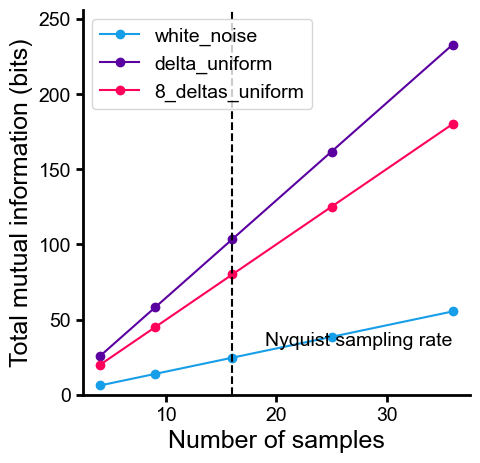

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)[:, None]
    max_mi = np.max(total_mi, axis=1)

    # ax.plot(num_samples, mutual_information, 'o-')
    ax.plot(num_samples_list, max_mi, 'o-', label=object_name)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(max_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

## Show phase transition behavior with increasing Nyquist samples

In [ ]:
N_objects = 2000
num_bootstraps = 10
noise_sigma = 1e-3
num_samples = np.linspace(2, 96, 15).astype(int)
num_nyquist_samples_list = [8, 16, 24, 32, 48]



objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)])

mi_vs_num_nyquist_samples = {}
for num_nyquist_samples in tqdm(num_nyquist_samples_list):

  mutual_information = []
  for N in tqdm(num_samples):
    erasure_mask = onp.zeros(OBJECT_LENGTH)
    sample_indices = onp.linspace(0, OBJECT_LENGTH - 1, N).astype(int)
    erasure_mask[sample_indices] = 1
    erasure_mask = np.array(erasure_mask, dtype=bool)
    mi_bootstraps = []
    for k in range(num_bootstraps):
      initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, erasure_mask, num_nyquist_samples=num_nyquist_samples, nyquist_sample_output=False)
      mi_bootstraps.append(optimized_mi)

    mutual_information.append(onp.array(mi_bootstraps).max())
  mi_vs_num_nyquist_samples[num_nyquist_samples] = mutual_information


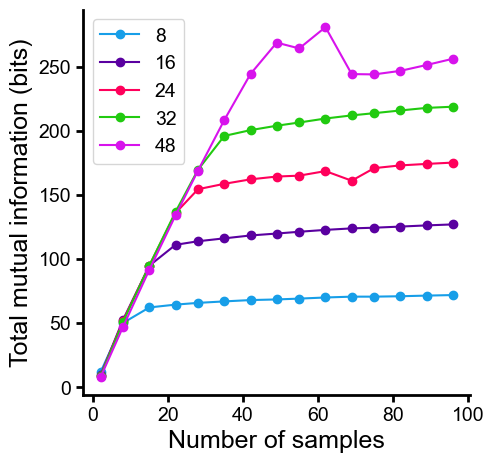

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for num_nyquist_samples, mutual_information in mi_vs_num_nyquist_samples.items():

    total_mi = np.array(mutual_information) * num_samples


    # ax.plot(num_samples, mutual_information, 'o-')
    ax.plot(num_samples, total_mi, 'o-', label=num_nyquist_samples)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
# ax.axvline(num_nyquist_samples, linestyle='--', color='k')
# ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

## Show transition behavior with different SNR levels

In [ ]:
N_objects = 2000
num_bootstraps = 10
num_samples = np.linspace(2, 96, 15).astype(int)

objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)])

noise_sigma_list = [1e-6, 1e-5, 1e-4, 1e-3, 4e-3]

mi_vs_num_samples_by_noise = {}
for noise_sigma in tqdm(noise_sigma_list):
  mutual_information = []
  for N in num_samples:
    mi_bootstraps = []
    for k in range(num_bootstraps):
      initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, nyquist_sample_output=False)
      mi_bootstraps.append(optimized_mi)

    mutual_information.append(onp.array(mi_bootstraps).max())
  mi_vs_num_samples_by_noise[noise_sigma] = mutual_information


[Text(0.5, 1.0, 'SNR comparison')]

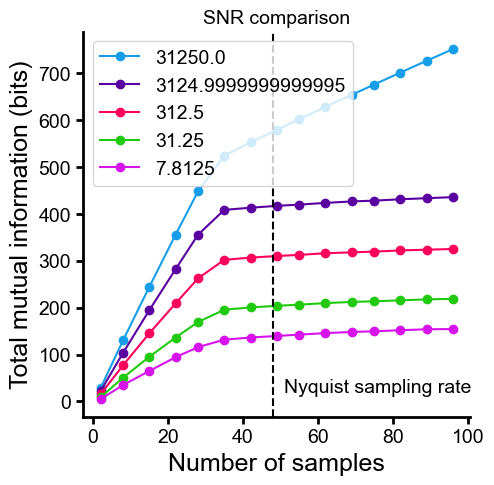

In [7]:
snrs = (1 / NUM_NYQUIST_SAMPLES) / np.array(noise_sigma_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for (noise_sigma, mutual_information), snr in zip(mi_vs_num_samples_by_noise.items(), snrs):

    total_mi = np.array(mutual_information) * num_samples

    # ax.plot(num_samples, mutual_information, 'o-')
    ax.plot(num_samples, total_mi, 'o-', label=snr)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(NUM_NYQUIST_SAMPLES, linestyle='--', color='k')
ax.text(NUM_NYQUIST_SAMPLES + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()
ax.set(title='SNR comparison')